# Numerical Simulation Laboratory                                                         
                                        Department of Physics, University of Milan(It)
                                        Spring 2020 
                                                                     Mattia Corigliano
## 8<sup>th </sup> Computational Exercise

## Variational Monte Carlo and Path Integral Monte Carlo

*In this computational exercise we used a variational monte carlo (VMC) code to estimate the ground-state energy of a single quantum particle in a one dimensional (1D) space confined by the following external potential:* 

\begin{equation} V(x) = x^4 -\frac{5}{2} x^2 \end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps

##  setting the Layout
import matplotlib as mpl
## LINES
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
## AXES
mpl.rcParams['axes.linewidth'] = 1 ## edge linewidth
mpl.rcParams['axes.grid'] = True ## display grid or not
mpl.rcParams['axes.titlesize'] = 16 ## fontsize of the axes title
#mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 14  ## fontsize of the x any y labels
mpl.rcParams['axes.formatter.limits'] = [-2,6] # use scientific notation if log10
mpl.rcParams['axes.formatter.use_mathtext'] = True # When True, use mathtext for scientific
mpl.rcParams['legend.fontsize'] = 12
## TICKS
mpl.rcParams['xtick.labelsize'] = 12 ## fontsize of the tick labels
mpl.rcParams['ytick.labelsize'] = 12 
mpl.rcParams['xtick.minor.visible'] = True ## visibility of minor ticks on x-axis
mpl.rcParams['ytick.minor.visible'] = True
## FIGURE
mpl.rcParams['figure.titleweight'] = 'bold' ## weight of the figure title
mpl.rcParams['figure.subplot.wspace'] = 0.4
mpl.rcParams['figure.subplot.hspace'] = 0.4
## ERRORBARS
mpl.rcParams['errorbar.capsize'] = 2  ## length of end cap on error bars in pixels

### A. Preliminary computation of the trial groud-state energy

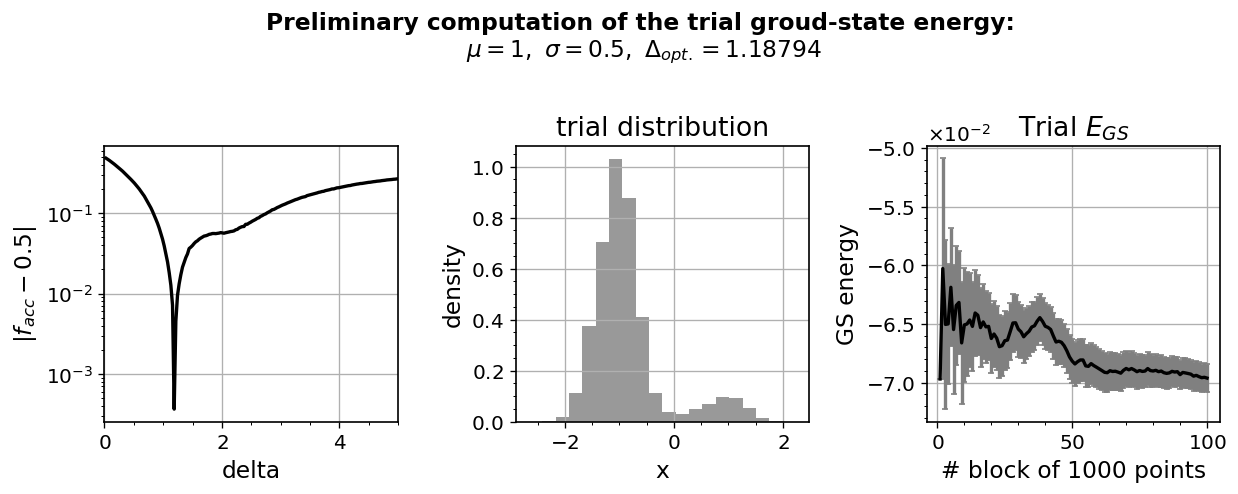

In [26]:
optimal_delta = np.loadtxt("data/preliminary_analysis/optimal_delta_value.txt").T
sampled_x = np.loadtxt("data/preliminary_analysis/trial_x.txt").T
trial_Egs = np.loadtxt("data/preliminary_analysis/trial_Egs.txt").T

fig = plt.figure(figsize=(12, 4), dpi=120)
fig.suptitle("Preliminary computation of the trial groud-state energy: \n$\mu=1, \ \sigma = 0.5, \ \Delta_{opt.} = 1.18794$", size=14)
mpl.rcParams['figure.subplot.top'] = 0.7

plt.subplot(1, 3, 1); 
plt.plot(optimal_delta[0], optimal_delta[1], 'k-')
plt.xlabel("delta")
plt.ylabel("$|f_{acc}-0.5|$")
plt.xlim(0, 5)
plt.semilogy()
plt.subplot(1, 3, 2); 
plt.hist(sampled_x[1], bins = 20, density = True, color = 'black', alpha = 0.4)
plt.xlabel("x")
plt.ylabel('density')
plt.title('trial distribution')
plt.subplots_adjust(wspace = 0.4)
# <GS|H|GS> trial
plt.subplot(1, 3, 3);
plt.title("Trial $E_{GS}$")
plt.errorbar(trial_Egs[0], trial_Egs[1], yerr=trial_Egs[2], color='black', ecolor='gray')
plt.xlabel('# block of 1000 points')
plt.ylabel('GS energy')
plt.show()

The panel above shows an example of what our code do, given two values of $\mu$ and $\sigma$:
- it finds the optimal (to have 50% acceptance) delta value for metropolis 
- it generates points sampled from the given distribution
- it evaluates the ground-state energy with the blocking method.

###  B. Variational calculation of the ground-state energy

In this part of the exercise we used our variational monte carlo (VMC) code to find out the optimal values of $\mu$ and $\sigma$ that minimize the trial ground-state energy.

The minimization strategy uses simulated annealing and works like this:

1. get randomly generated guess: $\sigma,\mu$

2. find optimal delta value for metropolis 

3. sample points from the current guess distribution

4. evaluate $E_{loc}(\sigma,\mu)$

5. if it lowers the estimate of the GS accept the guess, otherwise accept it with a probability  $e^{-\frac{t}{\tau}}$, where $t$ is the number of steps and $\tau$ is a fine-tuned temperature for the system

6. repeat

The best values are:

$\mu = 0.795881$

$\sigma =  0.638836$

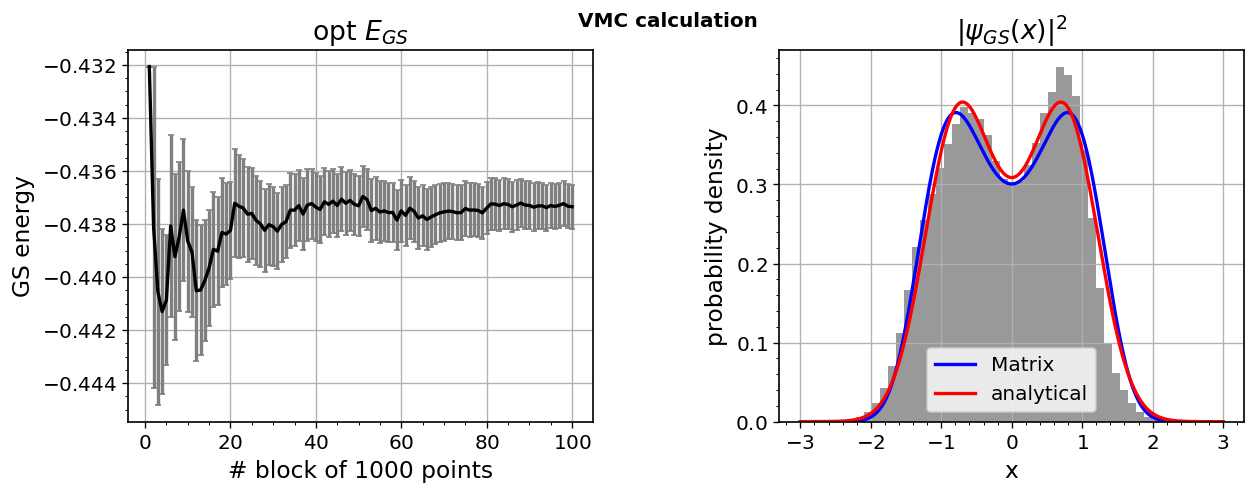

In [32]:
opt_x = np.loadtxt("data/optimized/optimized_x.txt").T
opt_Egs = np.loadtxt("data/optimized/optimized_Egs.txt").T

fig = plt.figure(figsize=(12, 4), dpi=120)
plt.suptitle("VMC calculation")
mpl.rcParams['figure.subplot.top'] = 0.9
plt.subplot(1, 2, 1);
plt.errorbar(opt_Egs[0], opt_Egs[1], yerr=opt_Egs[2], color='black', ecolor='gray')
plt.xlabel('# block of 1000 points')
plt.ylabel('GS energy')
plt.title("opt $E_{GS}$")

## sampled x
plt.subplot(1, 2, 2);
plt.hist(opt_x[1], bins = 50, density=True, color = 'black', alpha = 0.4)
plt.title("$|\psi_{GS}(x)|^2$")

## Matrix solution
def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 6
N = 1000 # number of iterations
# Step sizes
x1 = np.linspace(-a/2, a/2, N)
dx = x1[1] - x1[0] # the step size
V = Vpot(x1)
CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
E,psi = np.linalg.eigh(H)
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

plt.plot(x1, (psi[0])**2, color = 'b', label="Matrix")

## analytical
mu = 0.795881
sigma =  0.638836

def Opt_Psi(x):
    return np.exp(-(x-mu)**2/(2*sigma**2))+np.exp(-(x+mu)**2/(2*sigma**2))

y = Opt_Psi(x1)*Opt_Psi(x1)
N=simps(y,x1)
plt.plot(x1, y/N , 'r-', label="analytical")
plt.xlabel('x')
plt.ylabel('probability density')
plt.legend()

plt.show()

### C. PIMC calculation

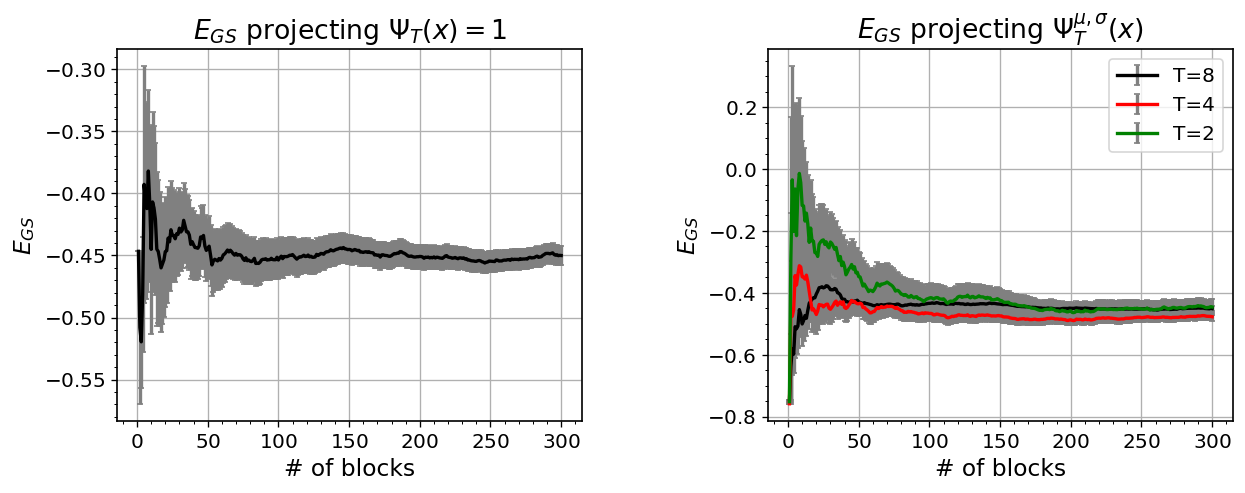

In [35]:
const_kinetic_pigs = np.loadtxt("QMC_1D/Results/pigs/const_kinetic.dat").T
const_potential_pigs = np.loadtxt("QMC_1D/Results/pigs/const_potential.dat").T
kinetic_pigs = np.loadtxt("QMC_1D/Results/pigs/kinetic.dat").T
potential_pigs = np.loadtxt("QMC_1D/Results/pigs/potential.dat").T
kinetic_pigs2 = np.loadtxt("QMC_1D/Results/pigs/T=4kinetic.dat").T
potential_pigs2 = np.loadtxt("QMC_1D/Results/pigs/T=4potential.dat").T
kinetic_pigs3 = np.loadtxt("QMC_1D/Results/pigs/T=2kinetic.dat").T
potential_pigs3 = np.loadtxt("QMC_1D/Results/pigs/T=2potential.dat").T

# PIGS
#preparing for data blocking...
blocks = np.arange(1, 301, 1)
def error(ave2, ave, n):
    if n==0:
        return 0
    else:
        return np.sqrt((ave2-ave*ave)/k)

fig = plt.figure(figsize=(12, 4), dpi=120)
plt.subplot(1, 2, 1);

energy = np.zeros(len(blocks))
for k in range(len(blocks)):
    energy[k] = const_kinetic_pigs[1][k]+const_potential_pigs[1][k]
    
#performing data blocking
ave = np.zeros(len(blocks))
ave2 = np.zeros(len(blocks))
blocking_error = np.zeros(len(blocks))
 
for k in range(len(blocks)):
    for j in range(k+1):
        ave[k] = ave[k] + energy[j]/(k+1)
        ave2[k] = ave2[k] + energy[j]*energy[j]/(k+1)
    blocking_error[k] = error(ave2[k], ave[k], k) 
    
plt.errorbar(blocks, ave, yerr=blocking_error, color='black', ecolor='gray')
plt.xlabel("# of blocks")
plt.ylabel("$E_{GS}$")
plt.title("$E_{GS}$ projecting $\Psi_T(x)=1$")

plt.subplot(1, 2, 2);
energy = np.zeros(len(blocks))
for k in range(len(blocks)):
    energy[k] = kinetic_pigs[1][k]+potential_pigs[1][k]
    
#performing data blocking
ave = np.zeros(len(blocks))
ave2 = np.zeros(len(blocks))
blocking_error = np.zeros(len(blocks))
 
for k in range(len(blocks)):
    for j in range(k+1):
        ave[k] = ave[k] + energy[j]/(k+1)
        ave2[k] = ave2[k] + energy[j]*energy[j]/(k+1)
    blocking_error[k] = error(ave2[k], ave[k], k) 
plt.errorbar(blocks, ave, yerr=blocking_error, color='black', ecolor='gray', label='T=8')
plt.xlabel("# of blocks")
plt.ylabel("$E_{GS}$")
plt.title("$E_{GS}$ projecting $\Psi^{\mu, \sigma}_T(x)$")

energy = np.zeros(len(blocks))
for k in range(len(blocks)):
    energy[k] = kinetic_pigs2[1][k]+potential_pigs2[1][k]
    
#performing data blocking
ave = np.zeros(len(blocks))
ave2 = np.zeros(len(blocks))
blocking_error = np.zeros(len(blocks))
 
for k in range(len(blocks)):
    for j in range(k+1):
        ave[k] = ave[k] + energy[j]/(k+1)
        ave2[k] = ave2[k] + energy[j]*energy[j]/(k+1)
    blocking_error[k] = error(ave2[k], ave[k], k) 
plt.errorbar(blocks, ave, yerr=blocking_error, color='r', ecolor='gray', label='T=4')

energy = np.zeros(len(blocks))
for k in range(len(blocks)):
    energy[k] = kinetic_pigs3[1][k]+potential_pigs3[1][k]
    
#performing data blocking
ave = np.zeros(len(blocks))
ave2 = np.zeros(len(blocks))
blocking_error = np.zeros(len(blocks))
 
for k in range(len(blocks)):
    for j in range(k+1):
        ave[k] = ave[k] + energy[j]/(k+1)
        ave2[k] = ave2[k] + energy[j]*energy[j]/(k+1)
    blocking_error[k] = error(ave2[k], ave[k], k) 
plt.errorbar(blocks, ave, yerr=blocking_error, color='g', ecolor='gray', capsize=2, label='T=2')

plt.legend()
plt.show()

We obtain comparable results in a range [2, 8]

**PIMC different temperatures**

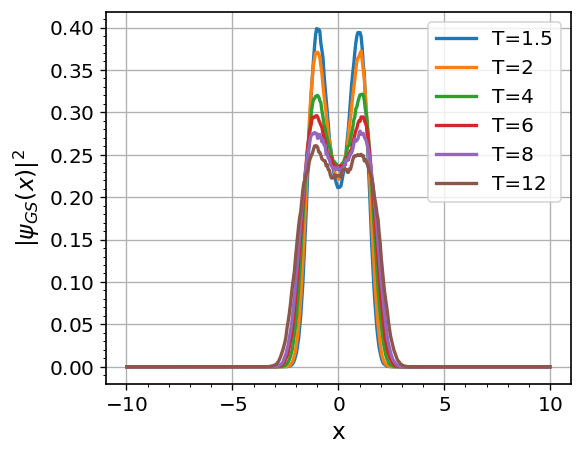

In [19]:
T = ['1.5', '2', '4', '6', '8', '12']

plt.figure(figsize=(5,4), dpi=120)

for t in T:
    config = np.loadtxt("QMC_1D/Results/pimc/T={}probability.dat".format(t)).T
    plt.plot(config[0], config[1], label='T={}'.format(t))
plt.xlabel("x")
plt.ylabel("$|\psi_{GS}(x)|^2$")
plt.legend()
plt.show()